# W4 G2 Validation : Jackknife and Bootstrap Resampling

## J.Jacobo – M. Hilmi

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error

### Jackknife
("leave-one-out" resampling)

<div>
<img src="jackknife.png" width="600"/>
</div>

**Key Facts**:
* Samples: For a dataset with n observations, there are exactly n possible resampled datasets.
* Resampling: Jackknife is deterministic (always produces the exact same results every time you run it).
* Replications: The number of samples is fixed at N, making it an "old-fashioned" but theoretically sound.

**Variance**:
$$ \textrm{SE}^2(\hat{\theta})=\frac{N-1}{N}\sum_{i=1}^N\left(\hat{\theta}(i)-\hat{\theta}(.)\right)^2 $$
where $\theta$ is the model's parameter.

### Synthetic Data
**Formula**:
$$y=b_0+b_1x_1+b_2x_2+b_3x_1x_2+b_4x_1^2+b_5x_2^2+\epsilon$$
where $\epsilon$ is artificial noise.

In [35]:
np.random.seed(42)

# ------------------------
# 1) Synthetic data
# ------------------------
n_samples = 150
x1 = np.random.uniform(-2, 2, n_samples)
x2 = np.random.uniform(-2, 2, n_samples)

# true quadratic + interaction surface
y_true = 1.5 + 2*x1 - 1.2*x2 + 0.8*x1*x2 - 0.5*x1**2 + 0.3*x2**2
y = y_true + 0.8 * np.random.randn(n_samples)

X = np.column_stack([x1, x2])

# ------------------------
# 2) Polynomial features + full model
# ------------------------
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)                           # shape (n_samples, n_features)
feature_names = ["intercept"] + list(poly.get_feature_names_out(["x1", "x2"]))

model_full = LinearRegression().fit(X_poly, y)
coef_nominal = np.concatenate(([model_full.intercept_], model_full.coef_))  # length = n_features + 1

# ------------------------
# 3) Jackknife (leave-one-out)
# ------------------------
jackknife_coefs = np.zeros((n_samples, coef_nominal.size))  # store intercept + weights

for i in range(n_samples):
    # leave i-th out
    X_jack = np.delete(X_poly, i, axis=0)
    y_jack = np.delete(y, i, axis=0)

    m = LinearRegression().fit(X_jack, y_jack)
    jackknife_coefs[i, 0] = m.intercept_
    jackknife_coefs[i, 1:] = m.coef_

# ------------------------
# 4) Jackknife statistic
# ------------------------
# mean of jackknife estimates
jack_mean = jackknife_coefs.mean(axis=0)       
sum_sq = np.sum((jackknife_coefs - jack_mean[None, :])**2, axis=0)
var_jack = (n_samples - 1) / n_samples * sum_sq
se_jack = np.sqrt(var_jack)

# 95% CI (normal approx) using jackknife SE (apply to nominal estimate)
ci_lower = coef_nominal - 1.96 * se_jack
ci_upper = coef_nominal + 1.96 * se_jack

# ------------------------
# 5) Grid predictions using jackknife coefficient sets
# ------------------------
grid_n = 40
x1_grid = np.linspace(X[:, 0].min(), X[:, 0].max(), grid_n)
x2_grid = np.linspace(X[:, 1].min(), X[:, 1].max(), grid_n)
X1g, X2g = np.meshgrid(x1_grid, x2_grid)
X_grid = np.column_stack([X1g.ravel(), X2g.ravel()])
X_grid_poly = poly.transform(X_grid)   # shape (grid_n*grid_n, n_features)

# compute predictions for each jackknife parameter vector
# note: jackknife_coefs rows are [intercept, coef1, coef2, ...]
jk_preds = []
for row in jackknife_coefs:
    intercept = row[0]
    weights = row[1:]
    y_pred = intercept + X_grid_poly @ weights
    jk_preds.append(y_pred.reshape(X1g.shape))

jk_preds = np.array(jk_preds)  # shape (n_samples, grid_n, grid_n)

# mean & std across jackknife samples (prediction uncertainty)
y_grid_mean = jk_preds.mean(axis=0)
y_grid_std = jk_preds.std(axis=0, ddof=1)
y_grid_lower = y_grid_mean - 1.96 * y_grid_std
y_grid_upper = y_grid_mean + 1.96 * y_grid_std

# ------------------------
# 6) Print concise coefficient table
# ------------------------
print("Coef    | Nominal    | JackSE    | 95% CI lower  | 95% CI upper")
print("-" * 85)
for i, name in enumerate(feature_names):
    print(f"{name:10s}  {coef_nominal[i]:9.4f}   {se_jack[i]:8.4f}   "
          f"{ci_lower[i]:11.4f}   {ci_upper[i]:11.4f}")

def plot_jackknife_surfaces(X, X1g, X2g, y, y_grid_mean, y_grid_lower, y_grid_upper, y_grid_std, jackknife_coefs, feature_names):

    plt.rcParams.update({'font.size': 10})
    fig = plt.figure(figsize=(12, 8))

    # 1) Mean surface + data
    ax1 = fig.add_subplot(221, projection='3d')
    ax1.scatter(X[:, 0], X[:, 1], y, color='tab:blue', alpha=0.6, s=18, label='Data')
    ax1.plot_surface(X1g, X2g, y_grid_mean, color='orange', alpha=0.65, linewidth=0, antialiased=True)
    ax1.set_title("Jackknife mean regression surface")
    ax1.set_xlabel("x1"); ax1.set_ylabel("x2"); ax1.set_zlabel("y")

    # 2) Mean surface + 95% band
    ax2 = fig.add_subplot(222, projection='3d')
    ax2.scatter(X[:, 0], X[:, 1], y, color='tab:blue', alpha=0.25, s=10)
    ax2.plot_surface(X1g, X2g, y_grid_mean, color='orange', alpha=0.7)
    ax2.plot_surface(X1g, X2g, y_grid_lower, color='red', alpha=0.18)
    ax2.plot_surface(X1g, X2g, y_grid_upper, color='green', alpha=0.18)
    ax2.set_title("Mean surface with jackknife 95% band")
    ax2.set_xlabel("x1"); ax2.set_ylabel("x2"); ax2.set_zlabel("y")

    # 3) Heatmap of prediction std
    ax3 = fig.add_subplot(223)
    cf = ax3.contourf(X1g, X2g, y_grid_std, levels=25, cmap='viridis')
    ax3.scatter(X[:, 0], X[:, 1], color='white', s=8, alpha=0.7)
    ax3.set_title("Prediction uncertainty (std dev) — jackknife")
    ax3.set_xlabel("x1"); ax3.set_ylabel("x2")
    plt.colorbar(cf, ax=ax3, label='std dev')

    # 4) Coefficient variability
    ax4 = fig.add_subplot(224)
    coef_variability = np.std(jackknife_coefs, axis=0, ddof=1)
    features_display = [name.replace(' ', '') for name in feature_names]
    ax4.bar(features_display, coef_variability, color='skyblue', alpha=0.7)
    ax4.set_ylabel('Standard Deviation')
    ax4.set_title('Jackknife Coefficient Variability')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    return fig


Coef    | Nominal    | JackSE    | 95% CI lower  | 95% CI upper
-------------------------------------------------------------------------------------
intercept      1.6230     0.1273        1.3734        1.8726
x1             2.0487     0.0519        1.9470        2.1505
x2            -1.2467     0.0601       -1.3645       -1.1289
x1^2          -0.5167     0.0521       -0.6188       -0.4146
x1 x2          0.8064     0.0487        0.7110        0.9017
x2^2           0.2690     0.0526        0.1658        0.3721


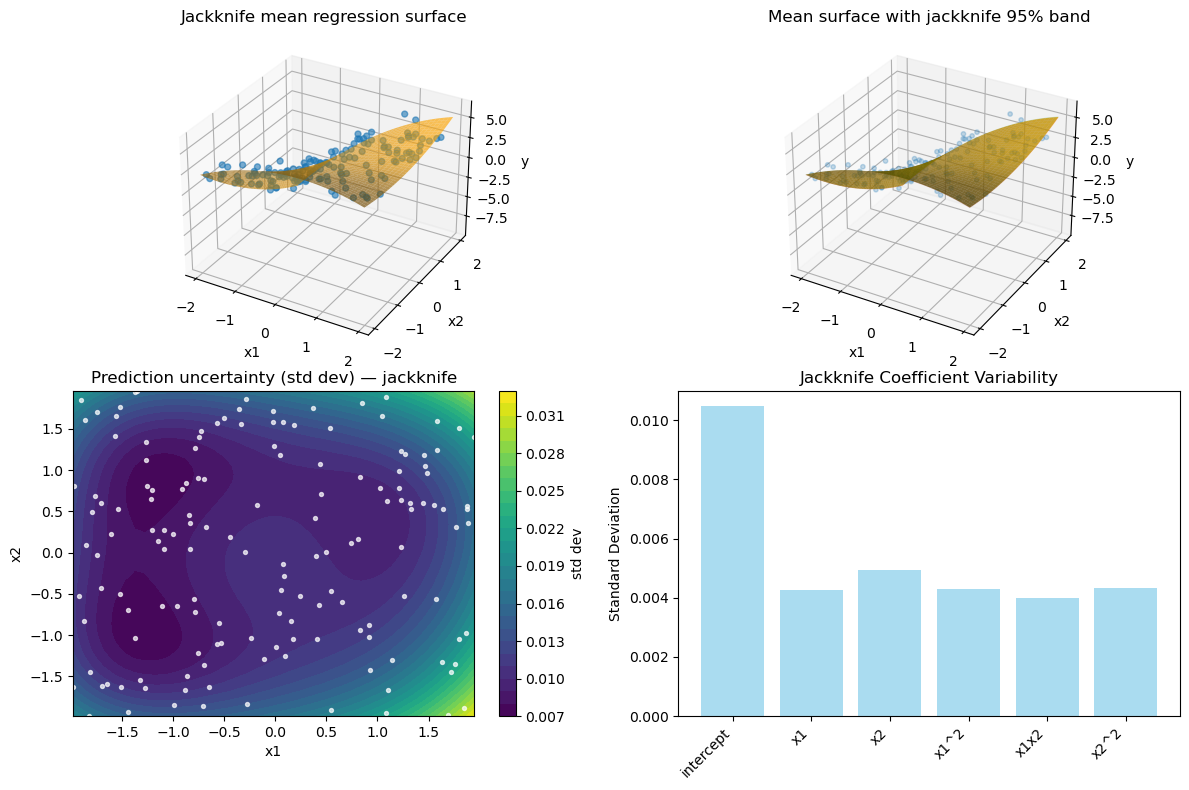

In [40]:
fig = plot_jackknife_surfaces(X, X1g, X2g, y, y_grid_mean, y_grid_lower, y_grid_upper, y_grid_std, jackknife_coefs, feature_names)

In [31]:
# Jackknife resampling (leave-one-out)
jackknife_coefs = []

for i in range(len(X)):
    # Leave out the i-th observation
    X_jack = np.delete(X, i, axis=0)
    y_jack = np.delete(y, i)
    
    # Transform and fit
    X_jack_poly = poly.transform(X_jack)
    m_jack = LinearRegression().fit(X_jack_poly, y_jack)
    
    # Store coefficients (intercept first)
    coef_jack = np.insert(m_jack.coef_, 0, m_jack.intercept_)
    jackknife_coefs.append(coef_jack)

jackknife_coefs = np.array(jackknife_coefs)

# Compute jackknife stats using jackknife variance formula
n = len(X)
coef_jack_mean = jackknife_coefs.mean(axis=0)

# Jackknife variance: (n-1)/n * sum((theta_i - theta_mean)^2)
coef_var = ((n - 1) / n) * np.sum((jackknife_coefs - coef_jack_mean) ** 2, axis=0)
coef_se = np.sqrt(coef_var)

# Jackknife bias estimate: (n-1) * (jackknife_mean - nominal_estimate)
coef_bias = (n - 1) * (coef_jack_mean - coef_nominal)

# Organize results in DataFrame
stats_df = pd.DataFrame({
    "Coefficient": feature_names,
    "Nominal": coef_nominal,
    "Jackknife_Mean": coef_jack_mean,
    "Jackknife_SE": coef_se,
    "Jackknife_Var": coef_var,
    "Jackknife_Bias": coef_bias
})

In [32]:
print("Jackknife Resampling Results:")
print("=" * 70)
print(stats_df.round(4))

Jackknife Resampling Results:
  Coefficient  Nominal  Jackknife_Mean  Jackknife_SE  Jackknife_Var  \
0   intercept   1.6230          1.6230        0.1273         0.0162   
1          x1   2.0487          2.0487        0.0519         0.0027   
2          x2  -1.2467         -1.2467        0.0601         0.0036   
3        x1^2  -0.5167         -0.5167        0.0521         0.0027   
4       x1 x2   0.8064          0.8064        0.0487         0.0024   
5        x2^2   0.2690          0.2689        0.0526         0.0028   

   Jackknife_Bias  
0          0.0015  
1         -0.0026  
2          0.0052  
3         -0.0014  
4          0.0026  
5         -0.0008  


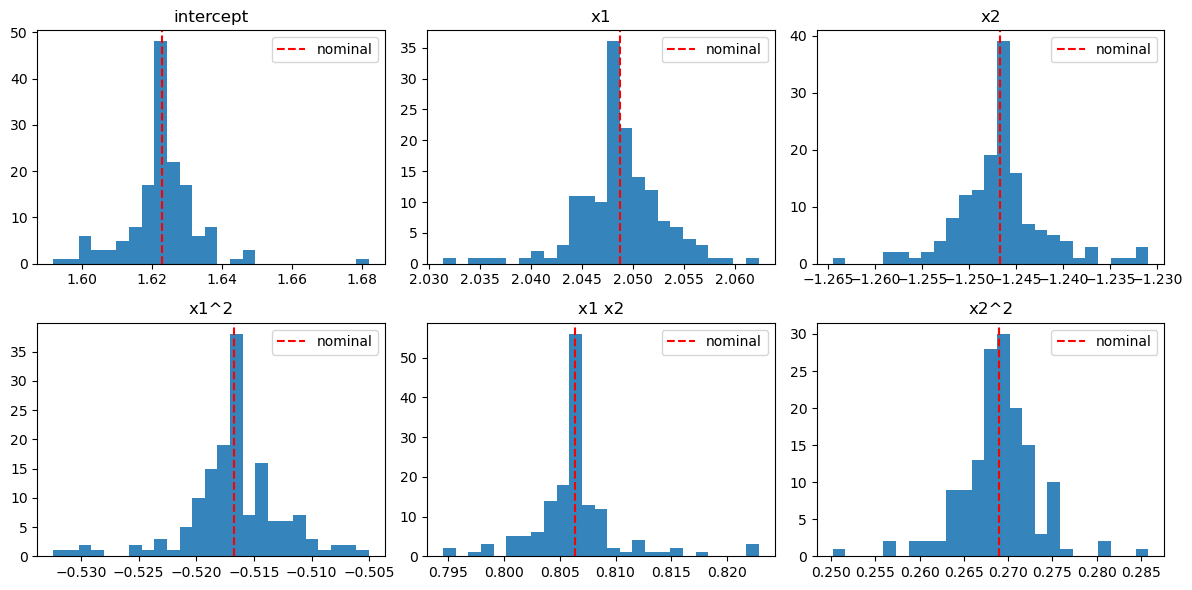

In [39]:
ncoef = coef_nominal.size
ncols = 3
nrows = int(np.ceil(ncoef / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3 * nrows))
axes = axes.flatten()
for i in range(ncoef):
    axes[i].hist(jackknife_coefs[:, i], bins=25, alpha=0.9)
    axes[i].axvline(coef_nominal[i], color='red', linestyle='--', label='nominal')
    axes[i].set_title(feature_names[i])
    axes[i].legend()
for j in range(ncoef, len(axes)):
    axes[j].set_visible(False)
plt.tight_layout()
plt.show()

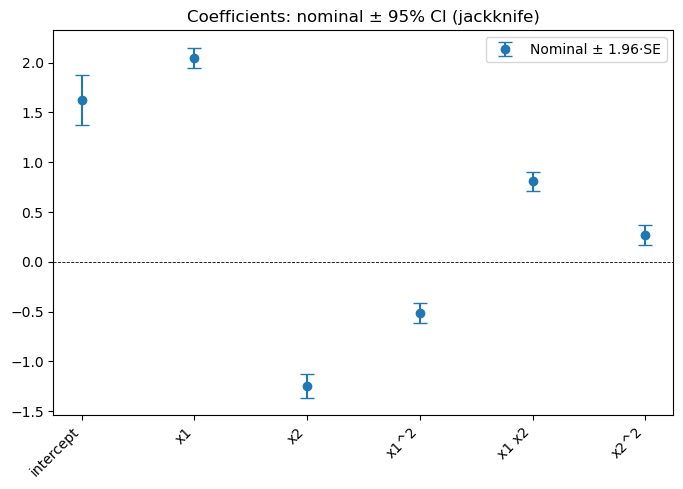

In [34]:
# ------------------------
# Errorbars of jackknife coefficient distributions
# ------------------------

fig, ax = plt.subplots(figsize=(8, 5))

xpos = np.arange(coef_nominal.size)
ax.errorbar(xpos, coef_nominal, yerr=1.96*se_jack, fmt='o', capsize=5, label='Nominal ± 1.96·SE')
ax.set_xticks(xpos); ax.set_xticklabels(feature_names, rotation=45, ha='right')
ax.set_title("Coefficients: nominal ± 95% CI (jackknife)")
ax.axhline(0, color='k', linestyle='--', linewidth=0.6)
ax.legend()

### Bootstrap
("sampling with replacement")

<div>
<img src="bootstrap.png" width="600"/>
</div>

**Key Facts**:
* Ideal bootstrap samples: \($N^N$\) possible resampled datasets.
* Number of replications: Choice of \($B$\) affects how much variability is captured.
* Resampling method: Uniform distribution sampling with replacement is commonly used.

**Variance**:
$$ \textrm{SE}^2(\hat{\theta})=\frac{\sum_{b=1}^B\left(\hat{\theta}_b^*-\bar{\theta}^*\right)^2}{B-1}. $$

In [2]:
np.random.seed(42)

# Synthetic data (2D inputs -> 1D output)
n_samples = 150
x1 = np.random.uniform(-2, 2, n_samples)
x2 = np.random.uniform(-2, 2, n_samples)

# True relationship (quadratic + interaction)
y_true = 1.5 + 2*x1 - 1.2*x2 + 0.8*x1*x2 - 0.5*x1**2 + 0.3*x2**2
y = y_true + 0.8 * np.random.randn(n_samples)  # add noise

X = np.column_stack([x1, x2])

# Polynomial regression
poly = PolynomialFeatures(degree=2, include_bias=True)
X_poly = poly.fit_transform(X)

model = LinearRegression()
model.fit(X_poly, y)

coef_nominal = model.coef_
coef_nominal[0] = model.intercept_  # adjust intercept placement
feature_names = poly.get_feature_names_out(["x1", "x2"])

In [3]:
# Create grid for visualization
x1_grid = np.linspace(X[:,0].min(), X[:,0].max(), 30)
x2_grid = np.linspace(X[:,1].min(), X[:,1].max(), 30)
X1_grid, X2_grid = np.meshgrid(x1_grid, x2_grid)

# Prepare grid for prediction
X_grid_poly = poly.transform(np.c_[X1_grid.ravel(), X2_grid.ravel()])
y_grid = model.predict(X_grid_poly).reshape(X1_grid.shape)

In [5]:
n_boot = 1000
boot_coefs = []

for _ in range(n_boot):
    X_res, y_res = resample(X, y)
    X_res_poly = poly.transform(X_res)
    m_boot = LinearRegression().fit(X_res_poly, y_res)
    coef_boot = m_boot.coef_
    coef_boot[0] = m_boot.intercept_
    boot_coefs.append(coef_boot)

boot_coefs = np.array(boot_coefs)

# Compute bootstrap stats
coef_se = boot_coefs.std(axis=0)
coef_var = boot_coefs.var(axis=0)

stats_df = pd.DataFrame({
    "Coefficient": feature_names,
    "Nominal": coef_nominal,
    "Bootstrap_SE": coef_se,
    "Bootstrap_Var": coef_var
})

print(stats_df)

  Coefficient   Nominal  Bootstrap_SE  Bootstrap_Var
0           1  1.622978      0.126187       0.015923
1          x1  2.048723      0.051759       0.002679
2          x2 -1.246714      0.061381       0.003768
3        x1^2 -0.516688      0.051426       0.002645
4       x1 x2  0.806362      0.049880       0.002488
5        x2^2  0.268952      0.052438       0.002750


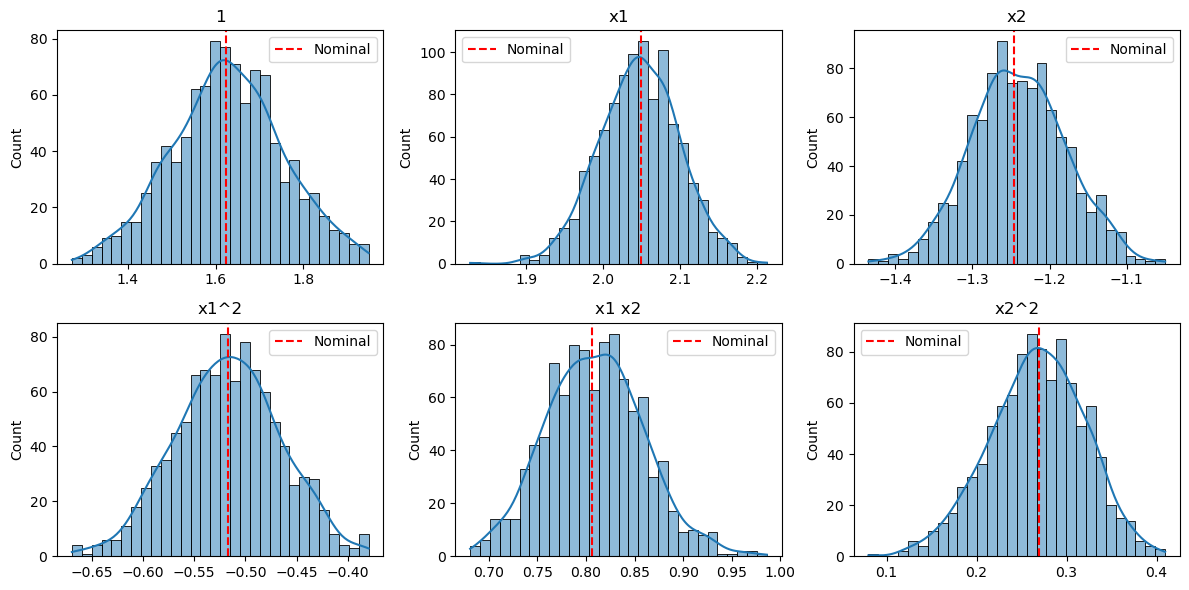

In [6]:
n_coef = len(feature_names)
fig, axes = plt.subplots(n_coef//3, 3, figsize=(12, 3*(n_coef//3)))
axes = axes.flatten()

for i in range(n_coef):
    sns.histplot(boot_coefs[:, i], bins=30, kde=True, ax=axes[i])
    axes[i].axvline(coef_nominal[i], color="red", linestyle="--", label="Nominal")
    axes[i].set_title(f"{feature_names[i]}")
    axes[i].legend()

plt.tight_layout()
plt.show()

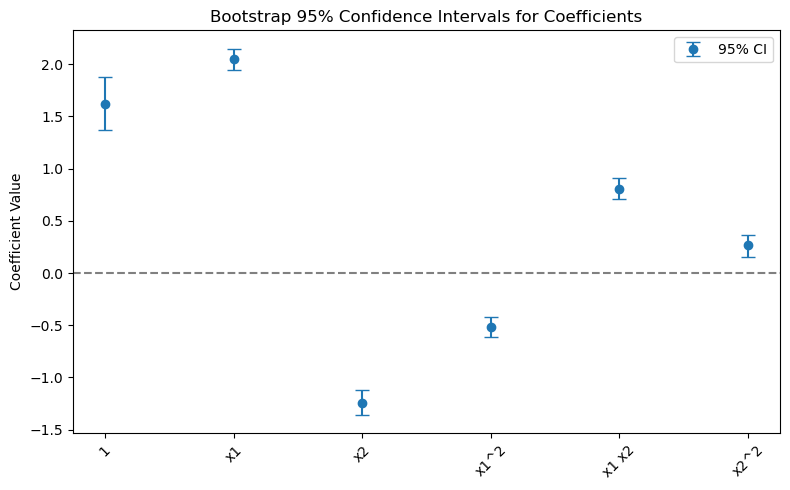

In [7]:
conf_intervals = np.percentile(boot_coefs, [2.5, 97.5], axis=0).T

fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(range(len(coef_nominal)), coef_nominal, 
            yerr=[coef_nominal - conf_intervals[:, 0], conf_intervals[:, 1] - coef_nominal], 
            fmt='o', capsize=5, label="95% CI")
ax.axhline(0, color='gray', linestyle='--')
ax.set_xticks(range(len(feature_names)))
ax.set_xticklabels(feature_names, rotation=45)
ax.set_ylabel("Coefficient Value")
ax.set_title("Bootstrap 95% Confidence Intervals for Coefficients")
ax.legend()
plt.tight_layout()
plt.show()

In [8]:
B = 1000  # number of bootstrap samples
n = len(y)

# Prepare polynomial features for nominal fit
poly2 = PolynomialFeatures(degree=2, include_bias=False)
poly3 = PolynomialFeatures(degree=3, include_bias=False)

X_poly2 = poly2.fit_transform(X)
X_poly3 = poly3.fit_transform(X)

# Nominal fits
model2_nom = LinearRegression().fit(X_poly2, y)
model3_nom = LinearRegression().fit(X_poly3, y)

# Nominal prediction errors
err2_nom = y - model2_nom.predict(X_poly2)
err3_nom = y - model3_nom.predict(X_poly3)

# Bootstrap errors storage
errs_2 = np.zeros((B, n))
errs_3 = np.zeros((B, n))

for b in range(B):
    # Bootstrap resample
    Xb, yb = resample(X, y, replace=True, n_samples=n)
    
    # 2nd order
    model2 = LinearRegression().fit(poly2.transform(Xb), yb)
    errs_2[b] = y - model2.predict(X_poly2)
    
    # 3rd order
    model3 = LinearRegression().fit(poly3.transform(Xb), yb)
    errs_3[b] = y - model3.predict(X_poly3)

In [9]:
# Compute bootstrap statistics of errors
se_err2 = errs_2.std(axis=0, ddof=1)
se_err3 = errs_3.std(axis=0, ddof=1)

var_err2 = se_err2**2
var_err3 = se_err3**2

# --- Print summary ---
print("2nd-order model:")
print(" Nominal RMSE:", np.sqrt(mean_squared_error(y, model2_nom.predict(X_poly2))))
print(" Mean SE of errors:", se_err2.mean())
print(" Mean variance of errors:", var_err2.mean())

print("\n3rd-order model:")
print(" Nominal RMSE:", np.sqrt(mean_squared_error(y, model3_nom.predict(X_poly3))))
print(" Mean SE of errors:", se_err3.mean())
print(" Mean variance of errors:", var_err3.mean())

2nd-order model:
 Nominal RMSE: 0.7354249911055974
 Mean SE of errors: 0.14304081150969145
 Mean variance of errors: 0.02265014140770362

3rd-order model:
 Nominal RMSE: 0.7012030774125123
 Mean SE of errors: 0.18023256485384226
 Mean variance of errors: 0.036690162826994784


### Jackknife vs. Bootstrap
|Jackknife | Bootstrap |
|:----------|:----------|
| Leave-one-out resampling | Sampling with replacement |
| Computationally lighter, deterministic | Heavier, results vary across runs |
| Conservative, underperform on non-smooth statictics | More accurate, handles skew/skewed data better |
| Good for bias reduction, small samples | Broad applications (SE, CI, bias, prediction error) |

**Analogy**: Jackknife = small handy tool; Bootstrap = full workshop of tools.

### Reference
**Jackknife**:
* McIntosh, A. (2016). The jackknife estimation method [Article]. arXiv. https://arxiv.org/abs/1606.00497.
* Elsevier. (n.d.). Jackknife resampling [Notes]. ScienceDirect. https://www.sciencedirect.com/topics/mathematics/jackknife-resampling.
* Normalized Nerd. (2021). What is the jackknife resampling method? [Video]. YouTube. https://www.youtube.com/watch?v=3Z7yuFs7QWk.


**Bootstrap**:
* StatQuest with Josh Starmer. (2021). Bootstapping Main Ideas!!! [Video]. YouTube. https://www.youtube.com/watch?v=Xz0x-8-cgaQ.
* Huang, H. Jackknife-Bootstrap [Lecture notes]. U. C. Berkeley. https://www.stat.berkeley.edu/~hhuang/STAT152/Jackknife-Bootstrap.pdf.
* Glen, S. (2019). Resampling Methods: Bootstrap vs Jackknife [Article]. Data Science Central. https://www.datasciencecentral.com/resampling-methods-comparison/.